# Taking a look at public Venmo feed data

Looking at my Venmo feed one day, I got really curious about whether there were discernible trends in Venmo data. Happily, there's a public API, albeit an undocumented one, so I started taking a look. The analysis here, if I'm going to be honest, is halfassed at best, because I just wanted to get something to look at. I'll try to improve this over time, as I can.

Let's get some imports out of the way:

In [109]:
%matplotlib inline
import json
import requests
import sys
import matplotlib
from matplotlib import pyplot as plt
from datetime import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.probability import FreqDist
import numpy as np
import re

import string

## Getting the transactions
The following function scrapes unique transactions from the public venmo API. The number of transactions is specified by `limit` parameter. This can take a while, because the function is just polling the API until it has the required number. This data collection method limits a lot of what we can infer from this venmo data, because it's definitely not representative in time. A more involved way to do this would be to collect data over a much longer period - a week,or a month, to draw correlations of transaction activity with time. 

In [ ]:
VENMO_URL = 'https://venmo.com/api/v5/public'

def get_venmo_data(limit):
    url = VENMO_URL
    transactions = []
    existing_ids = set()
    
    while len(transactions) < limit:
        response = json.loads(requests.get(url).text)
        response_transactions = response['data']
        url = response['paging']['next']
        
        for transaction in response_transactions:
            if transaction['story_id'] not in existing_ids: 
                transactions.append(transaction)
                existing_ids.add(transaction['story_id'])
            if len(transactions) >= limit:
                break
    return transactions
    
        

transactions = get_venmo_data(10000)
        

In [14]:
print(json.dumps(transactions), file=open('transactions.json', 'w'))

In [2]:
transactions = json.loads(open('transactions.json', 'r').read())

I'm being lazy about the parsing of dates here, will update this soon. 

In [17]:
def parse_date(datestring):
    return datetime.strptime(datestring, '%Y-%m-%dT%H:%M:%S')

## Filtering Emoji

The following function attempts to generate a regex that will capture single-character wide emoji (for now). It gets the data from the Unicode specification for emoji, which at the time of writing is at version 5.0. Note that this regex contains redundancies, does not parse modified emoji into their compound form, or look at zero-width joiners. 

In [4]:
def get_emoji_regex():
    import re
    import requests
    def convert_char_range(rng):
        if '-' in rng:
            return '-'.join([chr(int(char, 16)) for char in rng.split('-')])
        else:
            return chr(int(rng, 16))
    text = requests.get('http://unicode.org/Public/emoji/latest/emoji-data.txt').text
    char_ranges = [line.split(';')[0].strip() for line in text.split('\n') if not (line.startswith('#') or line.strip() == '')]
    regex_ranges = [convert_char_range(rng.replace('..', '-')) for rng in char_ranges]
    regex_ranges.remove('0-9')
    regex = re.compile('[{}]'.format(''.join(regex_ranges)))
    return regex

In [6]:
regex = get_emoji_regex()

## Data analysis

The following code attempts to map frequency distributions on several variables:
- Stemmed words in the messages of the Venmo transactions, as seen in the `message` field. Stopwords and emoji are removed, as are words starting in punctuation. The latter step removes some quirks of the way nltk does word segmentation, like possessive phrases like `"Sam's"` being split into `["Sam", "'s"]`.
- The names of the users involved in the transactions - both the originator and the target. I'm only keeping track of first names here, because I thought that would be the interesting distribution. I'm disregarding targets that indicate things like transfers to bank accounts.
- Individual emoji, as determined by the above regex
- Profile creation dates of both users involved in the transaction

In the succeeding cells, those frequency distributions are plotted out.

In [26]:
messages = [t['message'] for t in transactions]

words = FreqDist()
names = FreqDist()
emoji = FreqDist()
num_emoji = 0
venmo_signup_dates = []

stemmer = SnowballStemmer('english')
stop_set = set(stopwords.words('english'))

for t in transactions:
    names[t['actor']['firstname']] += 1
    venmo_signup_dates.append(parse_date(t['actor']['date_created']))
    
    # at least with this data, there is only one transaction 
    target = t['transactions'][0]['target']
    if 'firstname' in target:
        names[t['transactions'][0]['target']['firstname']] += 1
    if 'date_created' in target:
        venmo_signup_dates.append(parse_date(t['transactions'][0]['target']['date_created']))
    
    for word in word_tokenize(t['message']):
        word = word.lower()
        if word in stop_set or word[0] in set(string.punctuation) or  regex.match(word):
            continue
        stem = stemmer.stem(word)
        words[stem] += 1
    
    for emoji_char in regex.findall(t['message']):
        if emoji_char in '0123456789': continue
        emoji[emoji_char] += 1

In [64]:
def plot_datetime_aspect(datetimes, f):
    dist = FreqDist(f(d) for d in datetimes)
    x = sorted(dist)
    y = [dist[i] for i in x]
    plt.plot(x,y)

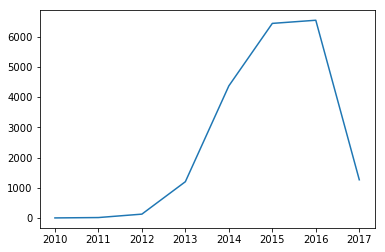

In [51]:
plot_datetime_aspect(venmo_signup_dates, lambda x: x.year)

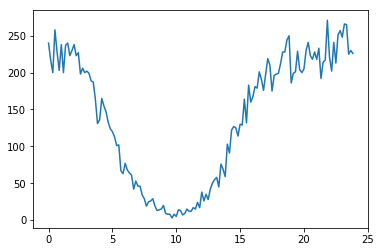

In [72]:
plot_datetime_aspect(venmo_signup_dates, lambda x: (x.hour + (x.minute//10)/6))

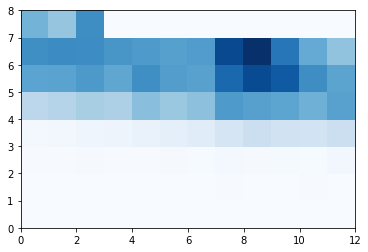

In [110]:
yearmonthmap = {}
for dt in venmo_signup_dates:
    year = dt.year
    month = dt.month
    if year in yearmonthmap:
        monthmap = yearmonthmap[year]
    else:
        monthmap = {i:0 for i in range(1,13)}
        yearmonthmap[year] = monthmap
    monthmap[month] = monthmap.get(month, 0) + 1

heatmatrix = np.array([[yearmonthmap[year][month] for month in sorted(yearmonthmap[year])] for year in sorted(yearmonthmap)])
heatmap = plt.pcolor(heatmatrix, cmap=matplotlib.cm.Blues)

Few surprises in the most common emoji - it's largely food and drink, with the understandable inclusions of gas, cars, and money.

The one slight surprise is the skin color modifiers in places 2 and 4. I'm guessing they show up because they apply to a wide variety of other emoji, none of which make the top 20 individually, but cumulatively  get close to the top. 

In [8]:
emoji.most_common(20)

[('🍕', 387),
 ('🏻', 172),
 ('💸', 162),
 ('🏼', 133),
 ('🌮', 121),
 ('❤', 111),
 ('🍻', 111),
 ('🍺', 110),
 ('🎉', 109),
 ('🍷', 105),
 ('🏀', 102),
 ('🍴', 99),
 ('🍔', 96),
 ('⛽', 93),
 ('🍣', 91),
 ('💩', 86),
 ('🍹', 85),
 ('🚗', 80),
 ('🍜', 76),
 ('🏠', 76)]

The common words show a lot of correlation with the emoji being used - food and drink are prominent. Uber appears in the number two spot at 147 mentions - apparently people really haven't figured out the ride splitting feature. Its rival Lyft on the other hand, doesn't make the top 20, coming in at 22 mentions. 

From these words, we also see a lot of transactions that might be between roommates - groceries, bills, and rent all make the cut, and are likely also behind the inclusion of "march" in the top words, given when this data was gathered.

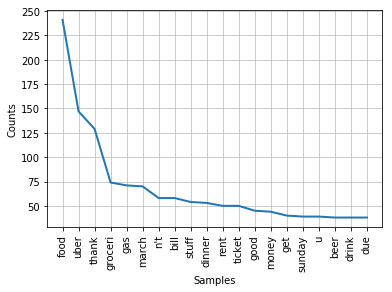

Uber: 147
Lyft: 22


In [96]:
words.plot(20)
print('Uber: {}'.format(words['uber']))
print('Lyft: {}'.format(words['lyft']))

In [86]:
names.most_common(20)

[('Michael', 254),
 ('Ryan', 200),
 ('Emily', 198),
 ('Alex', 191),
 ('Andrew', 187),
 ('Lauren', 152),
 ('Matt', 148),
 ('Chris', 145),
 ('Sarah', 145),
 ('Kevin', 144),
 ('Matthew', 137),
 ('David', 128),
 ('Nick', 122),
 ('Daniel', 121),
 ('Rachel', 114),
 ('John', 110),
 ('Jessica', 103),
 ('Sam', 102),
 ('Tyler', 101),
 ('Katie', 98)]